# Operations for basic photometry reduction using AutoPhOT


In [1]:
import os

In [2]:
import autophot

AutoPhOT requires input instructions
* Many of these are initial guesses and will be changed
* Need to load initial syntax

items in **bold** are parameters in the syntax dictionary that can be updated

In [3]:
# Load default input yaml file
from autophot.prep_input import load
syntax = load()

Default input loaded in from: 
/Users/seanbrennan/Documents/autophot_development/AutoPHoT_conda/autophot/autophot/databases/default_input.yml


Current build of AutoPhOT works of local computer
(Future builds will be accessed via website)
* Can give directory of fits file via **fits_dir** or single file via **fname**.


In [4]:
# Built in function to move some example data onto the users desktop
from autophot.example import save_example_data
fpath = save_example_data.save_fits_to_desktop()
dirpath = os.path.dirname(fpath)

Successful copy of example.fits written to:
/Users/seanbrennan/Desktop/autophot_example/example.fits


Example fits file should now be available on desktop.

We can now tell AutoPhoT that we want to work on this folder by updating **fits_dir**.

Similiarly we can update **fname** to */Users/*******/Desktop/autophot_example/example.fits to perform autophot a single file. AutoPhOT will ignore any files with template or wcs in the filename as these are used in template subtraction and astrometry.

In [5]:
syntax['fits_dir'] = dirpath

syntax['fname'] = None

AutoPhOT accounts for unique keywords found in different headers

*telescope.yml* will be created and keeps track of different file naming conventions. This file is stored in **wdir**. 

We will set this to the same directory as example.fits.

In [6]:



print('Setting work directory (wdir) to: %s' % dirpath)

# set working directory
syntax['wdir'] = dirpath

Setting work directory (wdir) to: /Users/seanbrennan/Desktop/autophot_example


Early version of code needs so additional parameters to get started

* Catalog version:
    * Currently available: Pan-STARRS, APASS, 2MASS and skymapper
    
* What transient you want to observe:
    * Enter either **target_name** to check TNS or **target_ra/target_dec** to observed specific source 
    
First we'll look at the example fits files using some packages from autophot

In [7]:
# Can choose skymapper, apass, pan_starrs, 2mass
syntax['catalog'] = 'skymapper'


<ipython-input-8-d06d213a1f2a>:20: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(data,


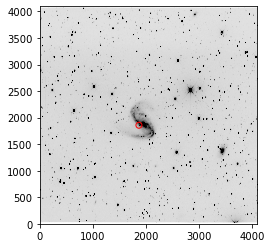

In [8]:
# autophot functions to find image data and header from fits files
from autophot.packages.functions import getimage
from autophot.packages.functions import getheader

# image
data = getimage(fpath)

# header
header = getheader(fpath)


# We will plot out the image 
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize,SquaredStretch,ZScaleInterval

# Create an ImageNormalize object
norm = ImageNormalize(stretch = SquaredStretch())
vmin,vmax = (ZScaleInterval(nsamples = 1000)).get_limits(data)

plt.imshow(data,
          vmin = vmin,
          vmax = vmax,
          norm = norm,
          origin = 'lower',
          cmap = 'Greys')

'''
For purpose of this example WCS is already in header. 
AutoPhOT is able to call astrometry.net from a local instance although for this example we assume the user doesn't
have astrometry installed
''' 

from astropy import wcs
w = wcs.WCS(header)

# Select a source - this source is not a transient although it is close to the center of the galaxy (NGC 2442)
ra = 114.070433
dec = -69.529716

# Choose a source in image
from astropy.coordinates import SkyCoord 
c = SkyCoord(ra,dec , unit="deg") 

x_pix,y_pix = w.all_world2pix(c.ra.degree, c.dec.degree, 1)

plt.scatter(x_pix,y_pix,marker = 'o',facecolor = 'none',edgecolor = 'r')

plt.show()

Need to tell AutoPhOT where to look. Target photometry has several options:

* **target_name** give the TNS IAU name ignore SN/AT e.g. SN 1987A => 1987A

* **target_ra**/**target_dec** give ra/dec (in ICRS) in degrees (all coords in AutoPhOT use degrees)

* leave both **target_name** and **target_ra**/**target_dec** blank (i.e. null \ None) to perform calibration on image (astrometry, fwhm, zeropint etc) only


we enter the source given its ra/dec. Checking SkyMapper catalog, source at 114.070433 -69.529716 has r =  17.401 +/- 0.01

In [9]:
print('Performing photometry on source at ra/dec = %.6f/%.6f' %  (c.ra.degree,c.dec.degree))

# in this case this source isn't in TNS so we leave target_name as None and update target_ra and target_dec
syntax['target_ra'] = c.ra.degree
syntax['target_dec'] = c.dec.degree

Performing photometry on source at ra/dec = 114.070433/-69.529716


Input is now ready to run!

For this demonstration, example.fits has trusted wcs already in the header. AutoPhOT will detect wcs keywords (CRVAL1, CRVAL2, etc) and skip over this step. If the user wants to force new astrometry, regardless of what is already written, set **remove_wcs** to True.

AutoPHoT relies on a user side dictionary of telescope data. Before starting, AutoPhOT will run through all files and ensure all keywords are known. It will ask the user to clariy any non-standard keywords. This may take away from the automation side of things but such steps only need to be taken once and it allows smoother operations if working with many files. For the purpose of this example there is no need in input scale_type or scale_units as we will not be needed astrometry.net so user can type *skip*. You'll see that if you rerun the script it won't ask you for this parameters as it check the pre-existing keys beforehand.

***We recommend you familirise yourself with this  example on how telescope.yml works see [here](https://github.com/Astro-Sean/autophot/blob/master/example_call_database.ipynb) ***

This script (*write_yaml.yml*) is still underdevelopment as it needs to be be broad enough to accept various file structures and thusly, might fail. We hope to minimise these failures but as a backup, one can manually update the *telescope.yml* file.

To allow for a batch of files to be run, terminated and restarted from the same instance we have **restart** keyword that is defaulted to True. Leaving this command on will ignore any files that have already been ran through by the code. (i.e. it will look for the out.csv file in the output folders)

In [10]:
from autophot.autophot import run_automatic_autophot

run_automatic_autophot(syntax)


    _       _       ___ _  _    _____
   /_\ _  _| |_ ___| _ \ || |__|_   _|
  / _ \ || |  _/ _ \  _/ __ / _ \| |
 /_/ \_\_,_|\__\___/_| |_||_\___/|_|

 ---------------------------------------
         AutoPhOT Beta
         S.J.Brennan et al. 2020 in prep
         Please provide feedback/bugs to:
         Email: sean.brennan2@ucdconnect.ie
---------------------------------------



AutoPhOT Version: 0.1.1
Checking internet connection...
Connected to internet

Directory of fits file: /Users/seanbrennan/Desktop/autophot_example

Restarting - checking for files already completed in:
/Users/seanbrennan/Desktop/autophot_example_REDUCED

Total Files: 1

Files already done: 0
- EXAMPLE_TELESCOPE

Adding new insturment: EXAMPLE_TELESCOPE

 *** Instrument Found ***
EXAMPLE_TELESCOPE -> INSTRUME -> EXAMPLE_INSTRUMENT
Simplified name [default: EXAMPLE_INSTRUMENT]: Example

Instrument pixel scale
Accepted scale units
Scale units [type skip to ignore]: skip

Similar gain keywords found
File: exam

File: example_APT.fits - PID: 10538
Start Time: 2021-02-14 16:06:24.448623
Telescope: EXAMPLE_TELESCOPE
Filter: r
MJD: 58849.000
Observation Date: 2020-01-01
Gain keyword not found - check telescope.yml - SETTING TO 1
Exposure time: 60s 
Detecting/removing cosmic ray sources


Starting Astroscrappy ... working ... this may take some time ... done
Exposure time: 60s :: Cosmic Ray Detections: 4048


Cosmic rays removed - image updated
WCS found
Using Gaussian Profile for fitting
Number of sources before cleaning - [s = 100.0]: 521 
Too many sources
Number of sources before cleaning - [s = 200.0]: 332 


-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source
-Saturated source


Isolated sources found [ 200 sigma ]: 295

Image FWHM: 4.617 +/- 0.153 

sigma:1.961

sigma_err:0.064

Aperture correction: -0.094 +/- 0.009
Searching for viable sources
New target name: target_ra_114_dec_-70
Searching for new catalog: skymapper 
Catalog length: 1426
Using Gaussian Profile for fitting


Matching catalog source to image: 244 / 771 

Average pixel offset: 2.112 


Matching catalog source to image: 253 / 771 

Using PSF Photometry
SNR: 7538 FWHM: 4.617


Residual table updated: 1 / 12 

SNR: 7120 FWHM: 4.617


Residual table updated: 2 / 12 

SNR: 6599 FWHM: 4.617


Residual table updated: 3 / 12 

SNR: 6487 FWHM: 4.617


Residual table updated: 4 / 12 

SNR: 6303 FWHM: 4.617


Residual table updated: 5 / 12 

SNR: 5735 FWHM: 4.617


Residual table updated: 6 / 12 

SNR: 5676 FWHM: 4.617


Residual table updated: 7 / 12 

SNR: 5548 FWHM: 4.617


Residual table updated: 8 / 12 

SNR: 5535 FWHM: 4.617


Residual table updated: 9 / 12 

SNR: 5395 FWHM: 4.617


Residual table updated: 10 / 12 

SNR: 5353 FWHM: 4.617


Residual table updated: 11 / 12 

SNR: 5201 FWHM: 4.617
Image_radius [pix] : 8.772 +/- 0.000
FWHM of PSF model: 4.617
Approx PSF mag -10.050
Image cutout size: (38,38) (38,38)
Fitting PSF to 250 sources


Residual table updated: 12 / 12   
Fitting PSF to source: 250 / 250


r-band zeropoint: 22.985 +/- 0.033 



Approx. limiting magnitude: 17.835 
Target photometry on original image
Fitting PSF to Target
Fitting PSF to 1 sources
Fitting gaussian to source to get FWHM
Target FWHM: 4.664
Image 1 / 1 saved
SNR = 68 - skipping limiting magnitude
Pixel Offset: 1.279

Target counts: 155.771 +/- 2.284
Target SNR: 68.213 +/- 0.016
Instrumental Magnitude: -5.481 +/- 0.016
Zeropoint: 22.985 +/- 0.033
Limiting Magnitude: skipped
Target Magnitude: 17.504 +/- 0.046 

*** Transient well detected ***

Time Taken [ 10538 ]: 151s
Sucess: example_APT.fits :: PID 10538 




---

Total failure : []

DONE
Recovering Output...
Data recovered :: Output File:
/Users/seanbrennan/Desktop/autophot_example_REDUCED/REDUCED.csv

Done - Time Taken: 1703.6


Output of AutoPhOT will be given in folder in either parent directory of the file (if **fname** is defined) or the parent dictionary of the fits_folder (if **fits_dir** is defined), below we display some of the visual outputs

AutoPhOT has automated PSF buillding and fitting feature - below is the target subtraction

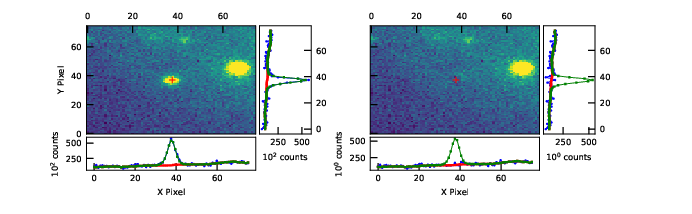

In [5]:
# Wand is used to display pdf images in jupyter notebooks - it is not needed for AutoPhoT
from wand.image import Image as WImage
PSF = WImage(filename = "/Users/seanbrennan/Desktop/autophot_example_REDUCED/example/target_psf_example_APT.pdf",
             resolution = 100)
PSF

Zeropint calibration from skymapper with some gentle sigma clipping

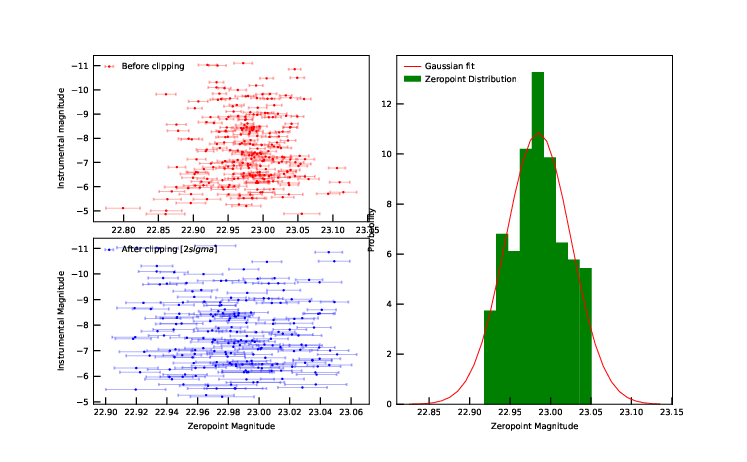

In [6]:
ZP = WImage(filename = "/Users/seanbrennan/Desktop/autophot_example_REDUCED/example/zp_example_APT.pdf",
            resolution = 100)
ZP

Magnitude recovery from PSF fitting in comparision to values from skymapper. We see the magnitude from the catalog minus the magnitude from the PSF fitting is fitted well

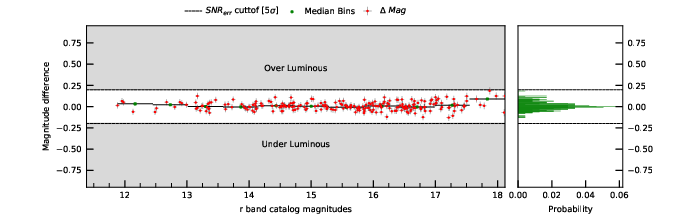

In [7]:
MAG_LIM= WImage(filename = "/Users/seanbrennan/Desktop/autophot_example_REDUCED/example/mag_lim_example_APT.pdf",
                resolution = 100)
MAG_LIM

Output image showing stars using for zeropoint (blue), PSF stars (Yellow) and tagrget (green)

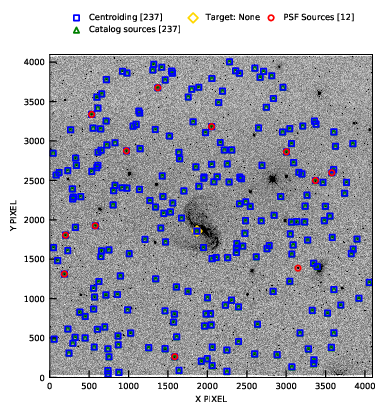

In [8]:
SOURCE_CHECK= WImage(filename = "/Users/seanbrennan/Desktop/autophot_example_REDUCED/example/source_check_example_APT.pdf",
                     resolution = 100)
SOURCE_CHECK